In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [35]:
# Load datasets
climate_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\climate.xlsx")
mortality_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\Mortality.xlsx")

In [4]:
mortality_df.dtypes

Year                                      int64
Date                                     object
Week                                      int64
DDS (Dates after the Date of Sowing)      int64
Lots                                      int64
Block                                     int64
Number                                    int64
Hectares                                float64
Samples                                   int64
Defective Products                        int64
Lost                                      int64
Disease A (Phytoph.)                    float64
Disease B (Marchitas)                   float64
Disease C (Erwinia)                     float64
Other Varieties                         float64
Others                                  float64
Disease D (Picudo)                      float64
Intoxication                              int64
Total                                     int64
% Defective Products                     object
% Lost                                  

In [5]:
# Convert Date column to datetime and format properly
climate_df["Date"] = pd.to_datetime(climate_df["Date"]).dt.strftime('%Y-%m-%d')

# Aggregate climate data by Date
climate_agg = climate_df.groupby("Date").agg({
    "Average Temperature (°C)": "mean",  # Capture daily trends
    "Radiation (W/m2)": "mean",  # Light exposure variation
    "Rain (mm)": "sum",  # Total daily rainfall
    "UV index": "mean",  # Average UV exposure
    "Average Relative Humidity (%)" : "mean",
    "Maximum Relative Humidity (%)" : "mean",
    "Minimum Relative Humidity (%)" : "mean",
    "Soil Humidity (%)" : "mean"
}).reset_index()

# Rename columns back to original (removing any suffixes)
climate_agg.columns = ["Date", "Average Temperature (°C)", "Radiation (W/m2)", "Rain (mm)", "UV index", "Average Relative Humidity (%)",
                       "Maximum Relative Humidity (%)", "Minimum Relative Humidity (%)", "Soil Humidity (%)"]

# Verify the cleaned climate dataset
print(climate_agg.head())

         Date  Average Temperature (°C)  Radiation (W/m2)  Rain (mm)  \
0  2020-01-01                 26.195000        172.580417        0.6   
1  2020-01-02                 25.692708        164.351250        0.4   
2  2020-01-03                 25.257083        133.892083        0.0   
3  2020-01-04                 25.971458        136.229583        0.0   
4  2020-01-05                 25.545625        165.882917        0.2   

   UV index  Average Relative Humidity (%)  Maximum Relative Humidity (%)  \
0       NaN                      86.223958                      90.714583   
1       NaN                      86.849167                      91.991667   
2       NaN                      74.140625                      80.129167   
3       NaN                      82.550625                      84.083333   
4       NaN                      82.071667                      88.037500   

   Minimum Relative Humidity (%)  Soil Humidity (%)  
0                      80.812500          87.70604

In [6]:
# Extract unique months and years from the Date column
climate_agg["Date"] = pd.to_datetime(climate_agg["Date"])  # Ensure it's datetime
climate_agg["Year-Month"] = climate_agg["Date"].dt.to_period("M")  # Extract YYYY-MM format

# Get unique months
unique_months = climate_agg["Year-Month"].unique()
print("Unique months in the data:", unique_months)

Unique months in the data: <PeriodArray>
['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
 '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
 '2021-03', '2021-04', '2021-05', '2021-07', '2021-09', '2021-10', '2021-11',
 '2021-12', '2022-01', '2022-02', '2022-03', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
 '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05',
 '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11']
Length: 48, dtype: period[M]


In [36]:
# Convert the 'Date' column to datetime and format it as 'yyyy-mm-dd' in all DataFrames
#, mortality_df
for df in [climate_agg, mortality_df]:
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'],errors='coerce').dt.strftime('%Y-%m-%d')

C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\1877357334.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'],errors='coerce').dt.strftime('%Y-%m-%d')


In [17]:
# Merge Mortality & Climate dataset
mc_merged_df = pd.merge(climate_agg, mortality_df, on='Date', how='inner')

In [9]:
mc_merged_df.head()

,Date,Average Temperature (°C),Radiation (W/m2),Rain (mm),UV index,Average Relative Humidity (%),Maximum Relative Humidity (%),Minimum Relative Humidity (%),Soil Humidity (%),Year-Month,...,% Disease B (Marchitas),% Disease C (Erwinia),% Other Varieties,% Others,% Disease D (Picudo),% Intoxication,% Total,Affected Area,Not Sampled,Year-Week
0,2020-01-08,22.768125,42.455208,1.6,NaN,76.570208,84.577083,71.589583,88.03875,2020-01,...,0%,0%,0%,1.61%,0%,0%,1.61%,0.54%,0,2020-02
1,2020-01-08,22.768125,42.455208,1.6,NaN,76.570208,84.577083,71.589583,88.03875,2020-01,...,0%,0.12%,0%,0.24%,0%,0%,0.35%,0.41%,0,2020-02
2,2020-01-08,22.768125,42.455208,1.6,NaN,76.570208,84.577083,71.589583,88.03875,2020-01,...,0%,0%,0%,0.26%,0%,0%,0.26%,0.27%,0,2020-02
3,2020-01-08,22.768125,42.455208,1.6,NaN,76.570208,84.577083,71.589583,88.03875,2020-01,...,0%,0%,0%,0.54%,0%,0%,0.72%,0.54%,0,2020-02
4,2020-01-08,22.768125,42.455208,1.6,NaN,76.570208,84.577083,71.589583,88.03875,2020-01,...,0%,1.57%,0%,3.15%,0%,0%,4.72%,0.81%,0,2020-02


In [9]:
mc_merged_df.columns

Index(['Date', 'Average Temperature (°C)', 'Radiation (W/m2)', 'Rain (mm)',
       'UV index', 'Average Relative Humidity (%)',
       'Maximum Relative Humidity (%)', 'Minimum Relative Humidity (%)',
       'Soil Humidity (%)', 'Year-Month', 'Year', 'Week',
       'DDS (Dates after the Date of Sowing)', 'Lots', 'Block', 'Number',
       'Hectares', 'Samples', 'Defective Products', 'Lost',
       'Disease A (Phytoph.)', 'Disease B (Marchitas)', 'Disease C (Erwinia)',
       'Other Varieties', 'Others', 'Disease D (Picudo)', 'Intoxication',
       'Total', '% Defective Products', '% Lost', '% Disease A (Phytoph.)',
       '% Disease B (Marchitas)', '% Disease C (Erwinia)', '% Other Varieties',
       '% Others', '% Disease D (Picudo)', '% Intoxication', '% Total',
       'Affected Area', 'Not Sampled', 'Year-Week'],
      dtype='object')

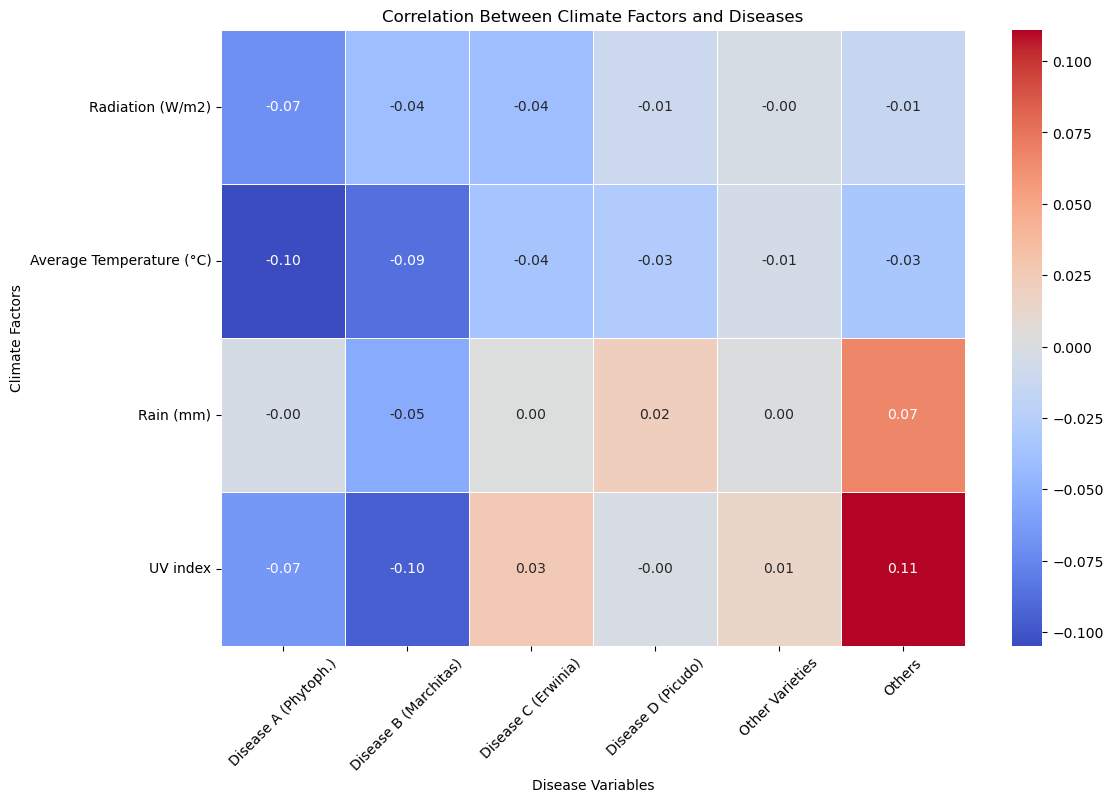

Correlation between Climate Factors and Diseases:
                          Disease A (Phytoph.)  Disease B (Marchitas)  \
Radiation (W/m2)                     -0.069855              -0.040197   
Average Temperature (°C)             -0.104766              -0.086519   
Rain (mm)                            -0.003612              -0.053462   
UV index                             -0.065762              -0.095214   

                          Disease C (Erwinia)  Disease D (Picudo)  \
Radiation (W/m2)                    -0.040408           -0.011000   
Average Temperature (°C)            -0.035257           -0.028648   
Rain (mm)                            0.002272            0.020861   
UV index                             0.026490           -0.001128   

                          Other Varieties    Others  
Radiation (W/m2)                -0.002536 -0.014021  
Average Temperature (°C)        -0.005104 -0.032465  
Rain (mm)                        0.001521  0.066592  
UV index              

In [13]:
# Define climate factors
climate_factors = ["Radiation (W/m2)", "Average Temperature (°C)", "Rain (mm)", "UV index"]

disease_columns = ['Disease A (Phytoph.)', 'Disease B (Marchitas)', 'Disease C (Erwinia)', 'Disease D (Picudo)',
       'Other Varieties', 'Others']

# Select only climate factors and disease categories
selected_columns = climate_factors + disease_columns
filtered_df = mc_merged_df[selected_columns]

# Drop missing values
filtered_df = filtered_df.dropna()

# Compute correlation matrix
correlation_matrix = filtered_df.corr()

# Extract only correlations between climate factors and diseases
correlation_subset = correlation_matrix.loc[climate_factors, disease_columns]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Climate Factors and Diseases")
plt.xlabel("Disease Variables")
plt.ylabel("Climate Factors")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Display correlation results
print("Correlation between Climate Factors and Diseases:")
print(correlation_subset)


In [11]:
mc_merged_df.columns

Index(['Date', 'Average Temperature (°C)', 'Radiation (W/m2)', 'Rain (mm)',
       'UV index', 'Average Relative Humidity (%)',
       'Maximum Relative Humidity (%)', 'Minimum Relative Humidity (%)',
       'Soil Humidity (%)', 'Year-Month', 'Year', 'Week',
       'DDS (Dates after the Date of Sowing)', 'Lots', 'Block', 'Number',
       'Hectares', 'Samples', 'Defective Products', 'Lost',
       'Disease A (Phytoph.)', 'Disease B (Marchitas)', 'Disease C (Erwinia)',
       'Other Varieties', 'Others', 'Disease D (Picudo)', 'Intoxication',
       'Total', '% Defective Products', '% Lost', '% Disease A (Phytoph.)',
       '% Disease B (Marchitas)', '% Disease C (Erwinia)', '% Other Varieties',
       '% Others', '% Disease D (Picudo)', '% Intoxication', '% Total',
       'Affected Area', 'Not Sampled', 'Year-Week'],
      dtype='object')

C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\261900409.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  disease_monthly = mortality_df["Total_Disease_Cases"].resample("M").sum()


MAE: 1052.56
RMSE: 1286.97
MAPE: 37.80%

 6-Month Disease Outbreak Forecast:
            Total_Disease_Forecast
2024-12-31                    1803
2025-01-31                    1723
2025-02-28                    3181
2025-03-31                    3259
2025-04-30                    2981
2025-05-31                    3656


C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\261900409.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=disease_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]


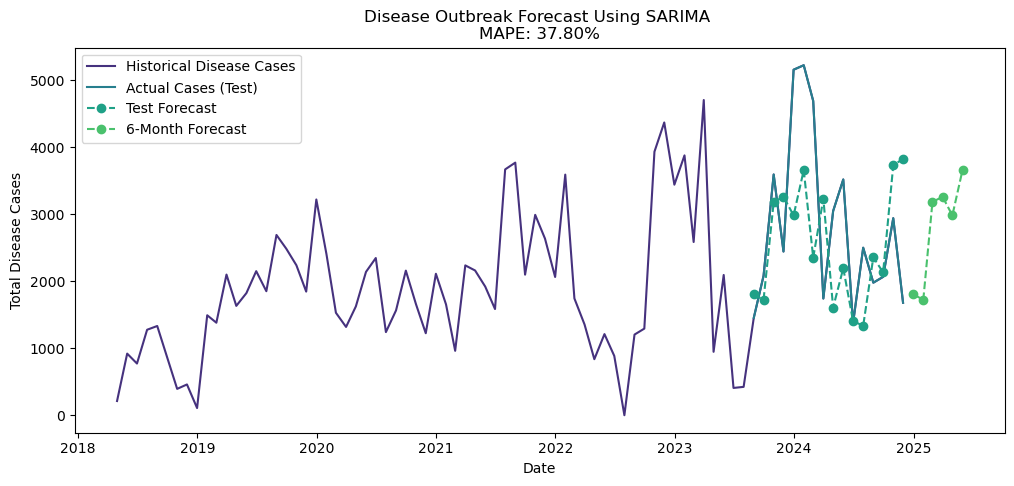

In [32]:
sns.set_palette("viridis")

# Convert Date Column & Set as Index
mortality_df["Date"] = pd.to_datetime(mortality_df["Date"])
mortality_df.set_index("Date", inplace=True)

# Aggregate Disease Data
disease_columns = ["Disease A (Phytoph.)", "Disease B (Marchitas)", 
                   "Disease C (Erwinia)", "Disease D (Picudo)",
                   "Others", "Other Varieties"]  

# Create a Total Disease Count column
mortality_df["Total_Disease_Cases"] = mortality_df[disease_columns].sum(axis=1)

# Resample Disease Data to Monthly Totals
disease_monthly = mortality_df["Total_Disease_Cases"].resample("M").sum()

# ]Train-Test Split (80% train, 20% test)
train_size = int(len(disease_monthly) * 0.8)
train, test = disease_monthly.iloc[:train_size], disease_monthly.iloc[train_size:]

# ] Define SARIMA Order (p, d, q) + Seasonal Order (P, D, Q, S)
sarima_order = (1, 1, 1)  # Regular ARIMA order
seasonal_order = (1, 1, 1, 12)  # Seasonal ARIMA with 12-month seasonality

# ] Fit SARIMA Model on Training Data
model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Make Predictions on the Test Set
test_forecast = np.ceil(model_fit.forecast(steps=len(test))).astype(int)

test_forecast.index = test.index  # Ensure forecast aligns with test data

# Compute Error Metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast) * 100

# Display Metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Forecast for the Next 6 Months
forecast_steps = 6
future_forecast = np.ceil(model_fit.forecast(steps=forecast_steps)).astype(int)

# Generate Future Dates
future_dates = pd.date_range(start=disease_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]

# Create Forecast DataFrame
forecast_df = pd.DataFrame({"Total_Disease_Forecast": future_forecast.values}, index=future_dates)

# Display Forecast
print("\n 6-Month Disease Outbreak Forecast:")
print(forecast_df)

#  Plot Historical Data + Future Forecast
plt.figure(figsize=(12, 5))
plt.plot(disease_monthly.index, disease_monthly, label="Historical Disease Cases", color=sns.color_palette("viridis")[0])
plt.plot(test.index, test, label="Actual Cases (Test)", color=sns.color_palette("viridis")[2])
plt.plot(test_forecast.index, test_forecast, "o--", label="Test Forecast", color=sns.color_palette("viridis")[3])
plt.plot(future_dates, future_forecast, "o--", label="6-Month Forecast", color=sns.color_palette("viridis")[4])
plt.xlabel("Date")
plt.ylabel("Total Disease Cases")
plt.title(f"Disease Outbreak Forecast Using SARIMA \nMAPE: {mape:.2f}%")
plt.legend()
plt.show()

C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\2153189475.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mortality_df["Date"] = pd.to_datetime(mortality_df["Date"])
C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\2153189475.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  disease_monthly = mortality_df["Total_Disease_Cases"].resample("M").sum()
C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\2153189475.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=disease_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]


MAE: 2385.90
RMSE: 2686.30
MAPE: 80.92%

 6-Month Disease Outbreak Forecast:
            Total_Disease_Forecast
2024-12-31              466.107267
2025-01-31              450.719941
2025-02-28              456.212514
2025-03-31              454.251916
2025-04-30              454.951760
2025-05-31              454.701948


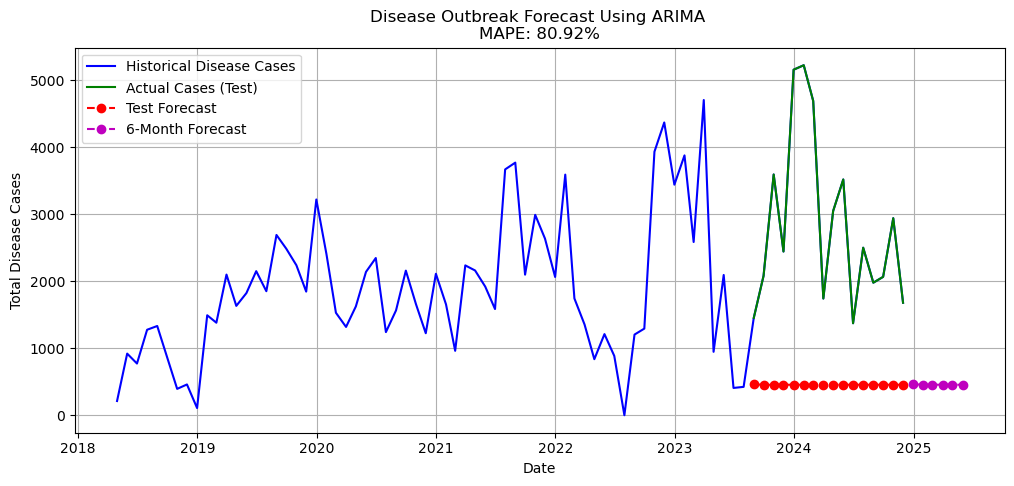

In [26]:
# Convert Date Column & Set as Index
mortality_df["Date"] = pd.to_datetime(mortality_df["Date"])
mortality_df.set_index("Date", inplace=True)

#  Aggregate Disease Data
disease_columns = ["Disease A (Phytoph.)", "Disease B (Marchitas)", 
                   "Disease C (Erwinia)", "Disease D (Picudo)",
                   "Others", "Other Varieties"]  

# Create a Total Disease Count column
mortality_df["Total_Disease_Cases"] = mortality_df[disease_columns].sum(axis=1)

# Resample Disease Data to Monthly Totals
disease_monthly = mortality_df["Total_Disease_Cases"].resample("M").sum()

# Train-Test Split (80% train, 20% test)
train_size = int(len(disease_monthly) * 0.8)
train, test = disease_monthly.iloc[:train_size], disease_monthly.iloc[train_size:]

# Define ARIMA Order (p, d, q)
arima_order = (1, 1, 1)  # Regular ARIMA order (No seasonality)

#  Fit ARIMA Model on Training Data
model = ARIMA(train, order=arima_order)
model_fit = model.fit()

#  Make Predictions on the Test Set
test_forecast = model_fit.forecast(steps=len(test))

# Compute Error Metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast) * 100

# Display Metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Step 8: Forecast for the Next 6 Months
forecast_steps = 6
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate Future Dates
future_dates = pd.date_range(start=disease_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]

# Create Forecast DataFrame
forecast_df = pd.DataFrame({"Total_Disease_Forecast": future_forecast.values}, index=future_dates)

# Display Forecast
print("\n 6-Month Disease Outbreak Forecast:")
print(forecast_df)

# Plot Historical Data + Future Forecast
plt.figure(figsize=(12, 5))
plt.plot(disease_monthly.index, disease_monthly, label="Historical Disease Cases", color="blue")
plt.plot(test.index, test, label="Actual Cases (Test)", color="green")
plt.plot(test.index, test_forecast, "ro--", label="Test Forecast")
plt.plot(future_dates, future_forecast, "mo--", label="6-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Total Disease Cases")
plt.title(f"Disease Outbreak Forecast Using ARIMA \nMAPE: {mape:.2f}%")
plt.legend()
plt.grid()
plt.show()

C:\Users\Arushi\AppData\Local\Temp\ipykernel_13656\1981664571.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disease_trend = mortality_df['Total_Disease_Cases'].resample('M').sum()


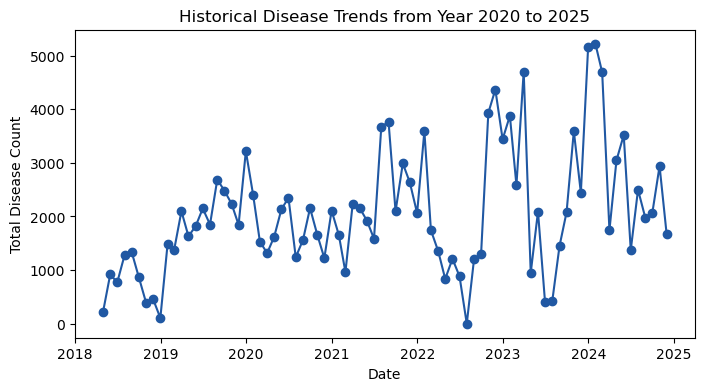

In [37]:
# Convert Date column to datetime format
mortality_df['Date'] = pd.to_datetime(mortality_df['Date'], errors='coerce')

disease_columns = ["Disease A (Phytoph.)", "Disease B (Marchitas)", 
                   "Disease C (Erwinia)", "Disease D (Picudo)",
                   "Others", "Other Varieties"]  

# Create a Total Disease Count column
mortality_df["Total_Disease_Cases"] = mortality_df[disease_columns].sum(axis=1)

# Set Date as index for time-series analysis
mortality_df = mortality_df.sort_values(by='Date').set_index('Date')

# Aggregate data by month
monthly_disease_trend = mortality_df['Total_Disease_Cases'].resample('M').sum()

# Plot the historical pest trends
plt.figure(figsize=(8, 4))
plt.plot(monthly_disease_trend, marker='o', linestyle='-', color='#2058A3')
plt.title("Historical Disease Trends from Year 2020 to 2025")
plt.xlabel("Date")
plt.ylabel("Total Disease Count")
plt.show()
